In [1]:
!pip install tf-nightly-2.0-preview


     |████████████████████████████████| 95.2MB 128kB/s 
     |████████████████████████████████| 450kB 43.9MB/s 
     |████████████████████████████████| 3.8MB 22.5MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.6.3 which is incompatible.
ERROR: tb-nightly 2.1.0a20191027 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


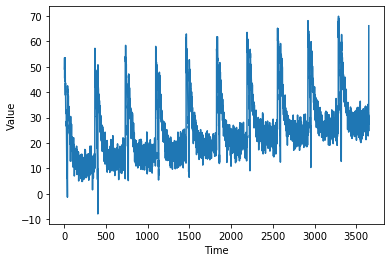

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 7s 71ms/step - loss: 31.4980 - mae: 31.8728
Epoch 2/100
94/94 [==============================] - 3s 28ms/step - loss: 30.3853 - mae: 30.8092
Epoch 3/100
94/94 [==============================] - 3s 29ms/step - loss: 29.1241 - mae: 29.6051
Epoch 4/100
94/94 [==============================] - 3s 28ms/step - loss: 27.7927 - mae: 28.2548
Epoch 5/100
94/94 [==============================] - 3s 29ms/step - loss: 26.2753 - mae: 26.7410
Epoch 6/100
94/94 [==============================] - 3s 29ms/step - loss: 24.5145 - mae: 25.0441
Epoch 7/100
94/94 [==============================] - 3s 29ms/step - loss: 22.6183 - mae: 23.1415
Epoch 8/100
94/94 [==============================] - 3s 29ms/step - loss: 20.4575 - mae: 21.0101
Epoch 9/100
94/94 [==============================] - 3s 29ms/step - loss: 18.1330 - mae: 18.6330
Epoch 10/100
94/94 [==============================] - 3s 29ms/step - loss: 15.5035 - mae: 16.0275
Epoch 11/100
94/94 [=========

[1e-08, 0.0001, 0, 30]

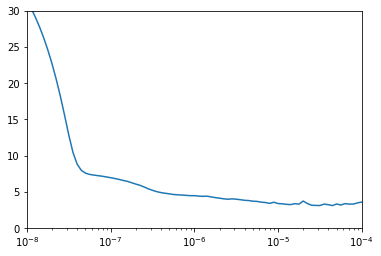

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=300,verbose=1)

Epoch 1/300
94/94 [==============================] - 7s 70ms/step - loss: 103.5571 - mae: 6.6816
Epoch 2/300
94/94 [==============================] - 3s 29ms/step - loss: 50.1293 - mae: 4.5489
Epoch 3/300
94/94 [==============================] - 3s 30ms/step - loss: 43.3716 - mae: 4.2745
Epoch 4/300
94/94 [==============================] - 3s 29ms/step - loss: 35.3486 - mae: 3.6944
Epoch 5/300
94/94 [==============================] - 3s 29ms/step - loss: 34.0231 - mae: 3.6941
Epoch 6/300
94/94 [==============================] - 3s 29ms/step - loss: 32.6741 - mae: 3.6459
Epoch 7/300
94/94 [==============================] - 3s 29ms/step - loss: 31.1700 - mae: 3.5507
Epoch 8/300
94/94 [==============================] - 3s 29ms/step - loss: 29.7001 - mae: 3.4226
Epoch 9/300
94/94 [==============================] - 3s 29ms/step - loss: 29.3827 - mae: 3.4378
Epoch 10/300
94/94 [==============================] - 3s 30ms/step - loss: 29.8308 - mae: 3.4837
Epoch 11/300
94/94 [==================

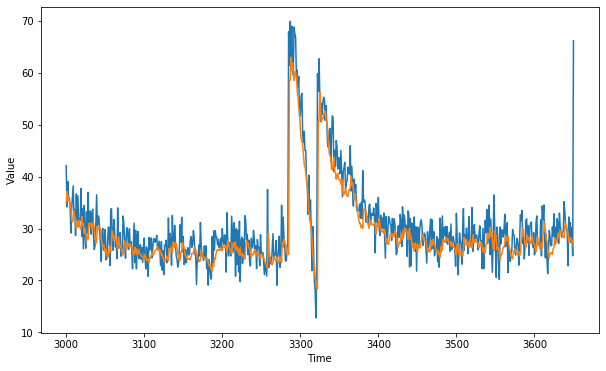

In [10]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.0847647

<Figure size 432x288 with 0 Axes>

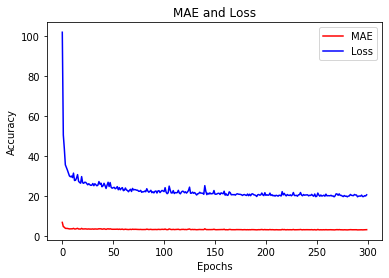

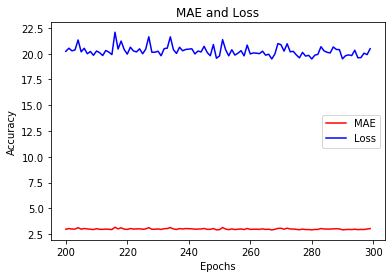

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()